-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------
# Text Mining and Social Media Mining
## SEMESTRAL PROJECT - SENTIMENT ANALYSIS OF TWEETS
### Aleksandra Tomczak, Aleksander Partyga
-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

The aim of this project is to perform a sentiment analysis on tweets connected with the Covid-19 pandemic. We would like to compare what emotions are dominant in posts of pro-vacciners and anti-vacciners. To achieve this goal we are going to compare the vocabulary used by each of the groups: both the most popular words and most popular hashtags used among those two groups. After that , the LDA was performed to distinguish dominating topics among the tweets.

In order to perform the analysis, the data from Twitter was scrapped for two positive and two negative hashtags - #VaccinesWork and #GetVaccinatedNow for pro-vaxxers, #VaccineSideEffects #Antivaxx for anti-vaxxers. We scraped 2500 tweets for each of the hashtags, then combined them within groups to form data frames that consist of 5000 tweets. Lastly, we chose only tweets from the users whose number of followers exceeds 100. The data was gathered in December 2021/ January 2022.

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

**The project consists of the following sections:**

**Part 1** - Necessary imports and downloads.

**Part 2** - Scraping data from Twitter.

**Part 3** - Text preprocessing and exploratory data analysis.

**Part 4** - Sentiment analysis.

**Part 5** - Latent Dirichlet allocation (LDA).

**Part 6** - Conclusions.

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

## Part 1 - Necessary imports and downloads.

In [1]:
import json
import csv
import tweepy
import re
import ast
import string
import nltk
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Function to display pandas dataframes side by side / one by one:

In [3]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

## Part 2 - Scraping data from Twitter.

In order to scrap the data from Twitter, we requested developer accounts through our private Twitter accounts. It gives the user limited access to the Twitter API, however, it was sufficient for the purpose of this project. Endpoints are accessed with the help of the Python library - *tweepy*. We used a function written by the user ritvikmath that is accessible on [GitHub](https://github.com/ritvikmath/ScrapingData/blob/master/Scraping%20Twitter%20Data.ipynb).

The input of the function consists of: consumer_key, consumer_secret, access_token, access_token_secret - obtained from the developer account mode, hashtag_phrase - the hashtag or the combination of hashtags to search for. The output of the function is a CSV file with the tweets and their content.

In [4]:
def search_for_hashtags(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase):
    
    # create authentication for accessing Twitter
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    # initialize Tweepy API
    api = tweepy.API(auth)
    
    # get the name of the spreadsheet we will write to
    fname = '_'.join(re.findall(r"#(\w+)", hashtag_phrase))

    # open the spreadsheet we will write to
    with open('%s.csv'%(fname),'w', encoding="utf-8") as file:

        w = csv.writer(file)

        # write header row to spreadsheet
        w.writerow(['timestamp', 'tweet_text', 'username', 'all_hashtags', 'followers_count'])

        # for each tweet matching our hashtags, write relevant info to the spreadsheet
        for tweet in tweepy.Cursor(api.search_tweets, q=hashtag_phrase+' -filter:retweets', \
                                   lang="en", tweet_mode='extended').items(2500):
            w.writerow([tweet.created_at, tweet.full_text.replace('\n',' ').encode('utf-8'), tweet.user.screen_name.encode('utf-8'), [e['text'] for e in tweet._json['entities']['hashtags']], tweet.user.followers_count])            

Next step is to input the consumer keys, download the tweets and generate a CSV file with tweets. The below procedure was repeated for all hashtags - positive: #VaccinesWork, #GetVaccinatedNow and negative: #VaccineSideEffects, #Antivaxx.

In [9]:
consumer_key = input('Consumer Key ')
consumer_secret = input('Consumer Secret ')
access_token = input('Access Token ')
access_token_secret = input('Access Token Secret ')  
hashtag_phrase = input('Hashtag Phrase ')

if __name__ == '__main__':
    search_for_hashtags(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase)

Consumer Key RhJNxtK3rQcYVHtnARCM4uEnb
Consumer Secret XwT9Mw6fgkIezQtlmIieaeLjFyRM2H81So9klSjpXVVlUsBU1O
Access Token 827690106-hIUZ24TVnttxeV8Iws2XDuThazqSgsN3wmuFVBJS
Access Token Secret 8KdCOYjtDAwY3S8VUcxfPh5zZJ9U9fiwFKJWqVmRzAkgu
Hashtag Phrase #VaccinesWork


The CSV files did not load properly into a pandas data frame due to some tweets downloaded with errors. We performed some data cleaning in Excel and then loaded the data from .xlsx into pandas. All tweets with errors were removed, as well as duplicates.

In [5]:
# load xlsx file into pandas data frame
df_pro = pd.read_excel('Pro_Hashtags.xlsx')

# filter tweets by the number of user's followers (more than 100)
df_pro = df_pro[df_pro["followers_count"] > 100]

# decode the text
df_pro["username"] = df_pro["username"].apply(ast.literal_eval).str.decode("utf-8")
df_pro["tweet_text"] = df_pro["tweet_text"].apply(ast.literal_eval).str.decode("utf-8")

# drop all the columns but the one containing the text of the tweet
tweets_pro = df_pro[["tweet_text"]]

In [6]:
# same procedure repeated for anti-vaccine tweets
df_anti = pd.read_excel('Anti_Hashtags.xlsx')

df_anti = df_anti[df_anti["followers_count"] > 100]

df_anti["username"] = df_anti["username"].apply(ast.literal_eval).str.decode("utf-8")
df_anti["tweet_text"] = df_anti["tweet_text"].apply(ast.literal_eval).str.decode("utf-8")

tweets_anti = df_anti[["tweet_text"]]

To avoid tweets posted by bots, we filtered them by the amount of followers of the user - the threshold was set at 100. It leaves us with 4417 tweet pro-vaccine and 4018 tweets anti-vaccine.

In [7]:
print(len(tweets_pro), len(tweets_anti))

4417 4018


In [8]:
display_side_by_side(tweets_pro.head(), tweets_anti.head())

,tweet_text
0,I think we should vaccinate all children.... quadruple jabs for all of them... by force if necessary. This virus doesn't care for human rights and neither do I. #getvaccinated #getvaccinatednow #vaccineswork https://t.co/2cZU3NlafM
1,@OBarromon @UseLogicBetter @CBSNews @FaceTheNation @margbrennan That's an unfair characterization. We would be in much deeper shit if the corrupt incompetents of TFG's administration were still running the country telling us it will all go away like a miracle without putting in the hard work. #GetVaccinatedNow
5,@ParentMishmash @leftylucieb @amyriscool @auntbunny22 @EmbryEthan I know 3 people with long Covid. One was unvaxxed and is now permanently disabled and will never leave a nursing home. He was a high powered financial advisor in NYC. Trashed his whole life and insurance has maxed out so he’s paying out-of-pocket. #GetVaccinatedNow #WearAMask
6,@amyriscool @ParentMishmash @auntbunny22 @EmbryEthan Except that the variants have come from other countries. It’s a global pandemic. Governments around the world need to get their populations vaxxed. This is how we got rid of polio and small pox…high global vaccination rates. #GetVaccinatedNow #WearAMask
7,"@Karenlovecheese What can I say other than thank you and your colleagues for your fortitude.We would be in an even worse situation without your heroic work. Under-staffed, underpaid, under resourced NHS. 😢❤️#GetVaccinatedNow"
,tweet_text
0,"Meanwhile, In #TheGreatReset #Authoritarian Proving Ground #Australia: #Unvaxxed #Aussies Told They Won’t Be Allowed to Exercise or Go to Work https://t.co/H5JMePs2dA #Covid_19 #VaccineMandate #VaccineSideEffects #vaccieapartheid #BigPharmaProfits #COVID19 #OmnicronVariant"
2,Deaths in young and working age males is on the rise Why? Or #OnlyCovidLivesMatter #istandwithnovak #VaccineDeaths #BoosterJab #OmicronVarient #VaccineSideEffects https://t.co/yUykjuLZKa
3,"#FakeNews #CNN Medical Guest: Let’s Penalize #Unvaccinated Americans, Deny Them Affordable Health Insurance...He must work for #BigPharma! https://t.co/ab6o4aAcAj #Covid_19 #VaccineMandate #VaccineSideEffects #vaccieapartheid #BigPharmaProfits #COVID19 #OmnicronVariant #omnicorn https://t.co/8OkUqSjm5m"
4,Defibrillators! Defibrillators! Everywhere you go! #VaccineSideEffects https://t.co/FhVVmEZvHr via @Verge


## Part 3 - Text preprocessing and exploratory data analysis.

Due to removal of some rows from pandas, the index in both *tweets_pro* and *tweets_anti* is not sequential, so we will first fix that.

In [9]:
# first line adds new index column with a sequential index, the second one drops the old index column
tweets_pro = tweets_pro.reset_index()
tweets_pro = tweets_pro.drop(columns = 'index')

tweets_anti = tweets_anti.reset_index()
tweets_anti = tweets_anti.drop(columns = 'index')

In [10]:
display_side_by_side(tweets_pro.head(), tweets_anti.head())

,tweet_text
0,I think we should vaccinate all children.... quadruple jabs for all of them... by force if necessary. This virus doesn't care for human rights and neither do I. #getvaccinated #getvaccinatednow #vaccineswork https://t.co/2cZU3NlafM
1,@OBarromon @UseLogicBetter @CBSNews @FaceTheNation @margbrennan That's an unfair characterization. We would be in much deeper shit if the corrupt incompetents of TFG's administration were still running the country telling us it will all go away like a miracle without putting in the hard work. #GetVaccinatedNow
2,@ParentMishmash @leftylucieb @amyriscool @auntbunny22 @EmbryEthan I know 3 people with long Covid. One was unvaxxed and is now permanently disabled and will never leave a nursing home. He was a high powered financial advisor in NYC. Trashed his whole life and insurance has maxed out so he’s paying out-of-pocket. #GetVaccinatedNow #WearAMask
3,@amyriscool @ParentMishmash @auntbunny22 @EmbryEthan Except that the variants have come from other countries. It’s a global pandemic. Governments around the world need to get their populations vaxxed. This is how we got rid of polio and small pox…high global vaccination rates. #GetVaccinatedNow #WearAMask
4,"@Karenlovecheese What can I say other than thank you and your colleagues for your fortitude.We would be in an even worse situation without your heroic work. Under-staffed, underpaid, under resourced NHS. 😢❤️#GetVaccinatedNow"
,tweet_text
0,"Meanwhile, In #TheGreatReset #Authoritarian Proving Ground #Australia: #Unvaxxed #Aussies Told They Won’t Be Allowed to Exercise or Go to Work https://t.co/H5JMePs2dA #Covid_19 #VaccineMandate #VaccineSideEffects #vaccieapartheid #BigPharmaProfits #COVID19 #OmnicronVariant"
1,Deaths in young and working age males is on the rise Why? Or #OnlyCovidLivesMatter #istandwithnovak #VaccineDeaths #BoosterJab #OmicronVarient #VaccineSideEffects https://t.co/yUykjuLZKa
2,"#FakeNews #CNN Medical Guest: Let’s Penalize #Unvaccinated Americans, Deny Them Affordable Health Insurance...He must work for #BigPharma! https://t.co/ab6o4aAcAj #Covid_19 #VaccineMandate #VaccineSideEffects #vaccieapartheid #BigPharmaProfits #COVID19 #OmnicronVariant #omnicorn https://t.co/8OkUqSjm5m"
3,Defibrillators! Defibrillators! Everywhere you go! #VaccineSideEffects https://t.co/FhVVmEZvHr via @Verge


Next, we created a separate column for the processed text and transformed all the characters into a lower case:

In [11]:
tweets_pro['tweet_processed'] = tweets_pro['tweet_text'].map(lambda x: x.lower())
tweets_anti['tweet_processed'] = tweets_anti['tweet_text'].map(lambda x: x.lower())

In [12]:
tweets_pro.head()

,tweet_text,tweet_processed
0,I think we should vaccinate all children.... q...,i think we should vaccinate all children.... q...
1,@OBarromon @UseLogicBetter @CBSNews @FaceTheNa...,@obarromon @uselogicbetter @cbsnews @facethena...
2,@ParentMishmash @leftylucieb @amyriscool @aunt...,@parentmishmash @leftylucieb @amyriscool @aunt...
3,@amyriscool @ParentMishmash @auntbunny22 @Embr...,@amyriscool @parentmishmash @auntbunny22 @embr...
4,@Karenlovecheese What can I say other than tha...,@karenlovecheese what can i say other than tha...


Next step is to remove emojis and other non-ascii characters from *tweet_processed* column.

In [13]:
def remove_emoji(_tweet):
    return _tweet.encode('ascii', 'ignore').decode('ascii')

In [14]:
tweets_pro['tweet_processed'] = tweets_pro['tweet_processed'].apply(remove_emoji)
tweets_anti['tweet_processed'] = tweets_anti['tweet_processed'].apply(remove_emoji)

After that, we created a function that removes the punctuation and stopwords and creates the list of words used in every tweet. Allowing '#' sign to remain in the list, as we want to separate hashtags from the word list later on.

In [96]:
# display content of string.punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [102]:
def text_process(_tweet):
    custom_punc = string.punctuation.replace('#', '') # leave the hashtags
    nopunc = [char for char in _tweet if char not in custom_punc] # remove punctuation character by character, create a list
    nopunc = ''.join(nopunc) # joins elements of the list
    return [word for word in nopunc.split() if word not in stopwords.words('english')] # split the string to words and remove the stopwords

In [16]:
tweets_pro['word_list'] = tweets_pro['tweet_processed'].apply(text_process)
tweets_anti['word_list'] = tweets_anti['tweet_processed'].apply(text_process)

Column *word_list* contains now the list of words used in a tweet without any punctuation or non-ascii characters:

In [17]:
tweets_pro['word_list'][1]

['obarromon',
 'uselogicbetter',
 'cbsnews',
 'facethenation',
 'margbrennan',
 'thats',
 'unfair',
 'characterization',
 'would',
 'much',
 'deeper',
 'shit',
 'corrupt',
 'incompetents',
 'tfgs',
 'administration',
 'still',
 'running',
 'country',
 'telling',
 'us',
 'go',
 'away',
 'like',
 'miracle',
 'without',
 'putting',
 'hard',
 'work',
 '#getvaccinatednow']

For stemmed tweets a separate column was created:

In [18]:
ps = PorterStemmer()

In [19]:
tweets_pro['tweet_stemmed'] = tweets_pro['word_list'].apply(lambda x: [ps.stem(word) for word in x])
tweets_anti['tweet_stemmed'] = tweets_anti['word_list'].apply(lambda x: [ps.stem(word) for word in x])

In [20]:
tweets_pro.head()

,tweet_text,tweet_processed,word_list,tweet_stemmed
0,I think we should vaccinate all children.... q...,i think we should vaccinate all children.... q...,"[think, vaccinate, children, quadruple, jabs, ...","[think, vaccin, children, quadrupl, jab, forc,..."
1,@OBarromon @UseLogicBetter @CBSNews @FaceTheNa...,@obarromon @uselogicbetter @cbsnews @facethena...,"[obarromon, uselogicbetter, cbsnews, facethena...","[obarromon, uselogicbett, cbsnew, facethen, ma..."
2,@ParentMishmash @leftylucieb @amyriscool @aunt...,@parentmishmash @leftylucieb @amyriscool @aunt...,"[parentmishmash, leftylucieb, amyriscool, aunt...","[parentmishmash, leftylucieb, amyriscool, aunt..."
3,@amyriscool @ParentMishmash @auntbunny22 @Embr...,@amyriscool @parentmishmash @auntbunny22 @embr...,"[amyriscool, parentmishmash, auntbunny22, embr...","[amyriscool, parentmishmash, auntbunny22, embr..."
4,@Karenlovecheese What can I say other than tha...,@karenlovecheese what can i say other than tha...,"[karenlovecheese, say, thank, colleagues, fort...","[karenlovechees, say, thank, colleagu, fortitu..."


We also created a separate columns with the list of hashtags used in a tweet.

In [21]:
find_hashtags = re.compile(r'#([A-Za-z0-9_]+)')
tweets_pro['hashtags'] = tweets_pro['tweet_text'].apply(lambda x: find_hashtags.findall(x))
tweets_anti['hashtags'] = tweets_anti['tweet_text'].apply(lambda x: find_hashtags.findall(x))

In [22]:
tweets_pro.tail()

,tweet_text,tweet_processed,word_list,tweet_stemmed,hashtags
4412,Took me almost a year to get my daughter to #G...,took me almost a year to get my daughter to #g...,"[took, almost, year, get, daughter, #getvaccin...","[took, almost, year, get, daughter, #getvaccin...","[GetVaccinated, Pfizer, VaccinesWork]"
4413,Wow. @Spotify chose Rogan and is pulling Neil ...,wow. @spotify chose rogan and is pulling neil ...,"[wow, spotify, chose, rogan, pulling, neil, yo...","[wow, spotifi, chose, rogan, pull, neil, young...",[VaccinesWork]
4414,@TorontoStar By all means keep that fear monge...,@torontostar by all means keep that fear monge...,"[torontostar, means, keep, fear, mongering, go...","[torontostar, mean, keep, fear, monger, go, th...","[Gaslighting, cdnpoli, cdnmedia, VaccinesWork]"
4415,“Biden Administration Withdraws Its Vaccine-Or...,biden administration withdraws its vaccine-or-...,"[biden, administration, withdraws, vaccineorte...","[biden, administr, withdraw, vaccineortest, ma...","[COVID19, covidvaccine, vaxnews, vaccines, vac..."
4416,I was an advocate for vaccines long before I w...,i was an advocate for vaccines long before i w...,"[advocate, vaccines, long, worked, space, face...","[advoc, vaccin, long, work, space, facebook, r...",[vaccineswork]


Next, the list of all words in pro-vaccine tweets and another list of all words in anti-vaccine tweets were created in a form of two long strings. We removed from both lists the words that contained numbers or were asociated directly with the topic of COVID19 vaccination.

In [23]:
all_words_pro = ' '.join([string for string in tweets_pro['word_list'].apply(lambda x: ' '.join(x))])
all_words_anti = ' '.join([string for string in tweets_anti['word_list'].apply(lambda x: ' '.join(x))])

In [269]:
# delete words that contain numbers
filtered_words_pro = ' '.join([s for s in all_words_pro.split() if not any(c.isdigit() for c in s)])
filtered_words_anti = ' '.join([s for s in all_words_anti.split() if not any(c.isdigit() for c in s)])

# delete words that contain patterns like "vaccin", "covid" etc.
filtered_words_pro = ' '.join(re.sub('.*covid.*|.*vaccin.*|.*boost.*|.*vaxx.*', '', w.lower()) for w in filtered_words_pro.split())
filtered_words_anti = ' '.join(re.sub('.*covid.*|.*vaccin.*|.*boost.*|.*vaxx.*', '', w.lower()) for w in filtered_words_anti.split())

We kept the hashtags as words, because many people use them in the middle of a sentence as a word replacement.

In [25]:
filtered_words_anti[:1000]

'meanwhile #thegreatreset #authoritarian proving ground #australia  #aussies told wont allowed exercise go work   #vaccieapartheid #bigpharmaprofits #omnicronvariant deaths young working age males rise  #istandwithnovak   #omicronvarient  httpstcoyuykjulzka #fakenews #cnn medical guest lets penalize  americans deny affordable health insurancehe must work #bigpharma   #vaccieapartheid #bigpharmaprofits #omnicronvariant #omnicorn defibrillators defibrillators everywhere go  httpstcofhvvmezvhr via verge  keeps us death   urgent govt investigation    sirgrahambrady daviddavismp telegraph mailonline dailymailuk spectator eamonnholmes mrmarkdolan marcusfysh draseemmalhotra trialed months rolled general public #istandwithnovak #djokovic  #masksdontwork look dont look look see   work get  #followthescience #theythinkyourestupid  lot cases theyre worse    #donotcomplyever   #crimesagainsthumanity #crimesagainstchildren httpstcoywkjtucexk  drug keeps government high    mostly  morons waiting lin

## Part 4 - Sentiment analysis.

### VADER compound score
Generating sentiment polarity with the use of VADER dictionary and computing the average VADER compound score for both groups.

In [26]:
sid = SentimentIntensityAnalyzer()

In [27]:
tweets_pro['scores'] = tweets_pro['tweet_text'].apply(lambda x: sid.polarity_scores(x))
tweets_pro['compound'] = tweets_pro['scores'].apply(lambda x: x['compound'])

tweets_anti['scores'] = tweets_anti['tweet_text'].apply(lambda x: sid.polarity_scores(x))
tweets_anti['compound'] = tweets_anti['scores'].apply(lambda x: x['compound'])

In [28]:
print("The average compound VADER score for pro-vaccine tweets was {}, while for anti-vaccine {}".format(round(tweets_pro['compound'].mean(), 2), round(tweets_anti['compound'].mean(), 2)))

The average compound VADER score for pro-vaccine tweets was 0.12, while for anti-vaccine -0.1


These results are inline with our initial intuition. As the authors of the VADER lexicon claim, compound score >= 0.05 suggests a positive sentiment whereas compound score <= -0.05 suggests a negative sentiment. Let's dive deeper to see what kind of vocabulary each of the groups use.

### Wordcloud
To visualize frequently used words, we created a WordCloud object for both strings containing tweet words.

In [29]:
wordcloud_pro = WordCloud(background_color = "white", max_words = 200, contour_width = 3, contour_color = 'steelblue')
wordcloud_anti = WordCloud(background_color = "white", max_words = 200, contour_width = 3, contour_color = 'steelblue')

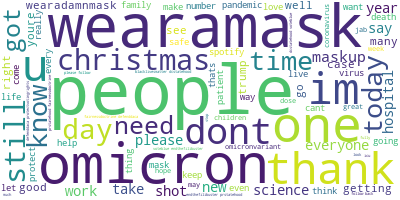

In [30]:
wordcloud_pro.generate(filtered_words_pro)
wordcloud_pro.to_image()

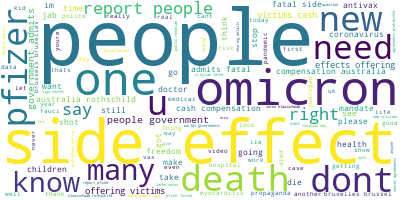

In [31]:
wordcloud_anti.generate(filtered_words_anti)
wordcloud_anti.to_image()

The wordclouds present the most frequently used words by both groups. Although we can see some interesting ones in pro-vaxxers like "thank" or "time" the majority of the words concern the vaccine and we are not able to draw conclusions about the overall sentiment of tweeter users. Hence, another vital step will be to remove hashtags, links, and redundant words (that will be defined in a list of stopwords).

### Visualizing most frequent words
To visualize the most frequent words, we will convert our long string of words into a pandas data frame where each word will have its frequency counted. Beforehand, we will tidy our dataset yet again by removing stopwords, links, and hashtags. Finally, we will plot the most frequently used words by both pro- and anti-vaxxers.

In [32]:
# split the string into a list of words
filtered_wordlist_pro = filtered_words_pro.split()
filtered_wordlist_anti = filtered_words_anti.split()

# remove hashtags and links
filtered_wordlist_pro = [ele for ele in filtered_wordlist_pro if not ele.startswith('#') and not ele.startswith("http") and not ele.startswith('bit.ly')]
filtered_wordlist_anti = [ele for ele in filtered_wordlist_anti if not ele.startswith('#') and not ele.startswith("http") and not ele.startswith('bit.ly')]

# remove stopwords
my_stopwords = ['get', 'amp', 'booster', 'omicron', 'im', 'one', 'us', 'dont', 'day', 'year', 'cases', 'getting', 'new', 'many', 'today', 'take', 'time', 'go', 'know', 'youre', 'got', 'would', 'even', 'make', 'see']
filtered_wordlist_pro = [word for word in filtered_wordlist_pro if word not in my_stopwords]
filtered_wordlist_anti = [word for word in filtered_wordlist_anti if word not in my_stopwords]

In [33]:
filtered_wordlist_pro[:10]

['think',
 'children',
 'quadruple',
 'jabs',
 'force',
 'necessary',
 'virus',
 'doesnt',
 'care',
 'human']

Now, we need to count how many times a certain word appeared among the tweets. To do that we used list method *count*.

In [34]:
# count how many times a word appears in a list
wordfreq_pro = [filtered_wordlist_pro.count(word) for word in filtered_wordlist_pro]
wordfreq_anti = [filtered_wordlist_anti.count(word) for word in filtered_wordlist_anti]

The code in a cell below creates a list of tuples: (word, frequency). After that we sorted the list in a descending order and chose first 20 words to be presented on the graph.

In [35]:
# zip the list of words with the list of frequencies, then transform it into a set to remove duplicates
# then transform into a list
uniq_freq_pro = list(set(zip(filtered_wordlist_pro, wordfreq_pro)))
uniq_freq_anti = list(set(zip(filtered_wordlist_anti, wordfreq_anti)))

In [36]:
# sort the list of tuples and leave 20 most frequent words
uniq_freq_pro = sorted(uniq_freq_pro, key = lambda tup: tup[1], reverse = True)[:20]
uniq_freq_anti = sorted(uniq_freq_anti, key = lambda tup: tup[1], reverse = True)[:20]

In [39]:
print(uniq_freq_pro[:5], uniq_freq_anti[:5])

[('people', 426), ('please', 261), ('christmas', 233), ('like', 216), ('still', 169)] [('people', 527), ('side', 219), ('effects', 198), ('report', 183), ('like', 164)]


Now we transformed the lists of 20 most used words with their frequencies into pamdas dataframes in order to visualize them.

In [40]:
# create a pandas data frame from tuples list
df_words_pro = pd.DataFrame(uniq_freq_pro, columns=['words', 'frequency'])
df_words_anti = pd.DataFrame(uniq_freq_anti, columns=['words', 'frequency'])

In [41]:
display_side_by_side(df_words_pro, df_words_anti)

,words,frequency
0,people,426
1,please,261
2,christmas,233
3,like,216
4,still,169
5,safe,154
6,good,153
7,need,140
8,everyone,139
9,thank,136


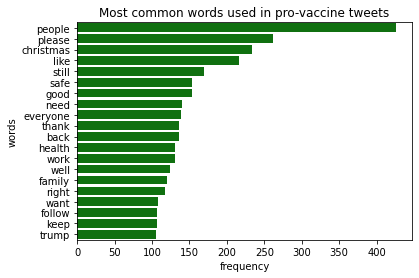

In [42]:
# plot the result
sns.barplot(x = 'frequency', y = 'words', data = df_words_pro, color = 'green').set(title = 'Most common words used in pro-vaccine tweets')
plt.xticks()
plt.show()

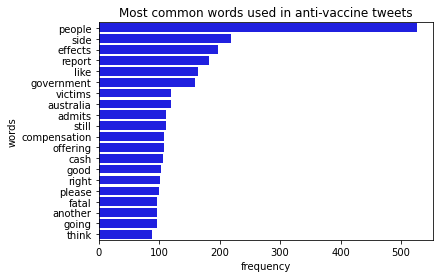

In [43]:
sns.barplot(x = 'frequency', y = 'words', data = df_words_anti, color = 'blue').set(title = 'Most common words used in anti-vaccine tweets')
plt.xticks()
plt.show()

As we can see, the most common used word in both cases turned out to be 'people'.

In [44]:
df_words_pro['scores'] = df_words_pro['words'].apply(lambda x: sid.polarity_scores(x))
df_words_pro['compound'] = df_words_pro['scores'].apply(lambda x: x['compound'])
print(round(df_words_pro['compound'].mean(),2))

0.11


In [45]:
df_words_anti['scores'] = df_words_anti['words'].apply(lambda x: sid.polarity_scores(x))
df_words_anti['compound'] = df_words_anti['scores'].apply(lambda x: x['compound'])
print(round(df_words_anti['compound'].mean(),2))

0.03


In [288]:
display_side_by_side(df_words_pro[:20], df_words_anti[:20])

,words,frequency,scores,compound
0,people,426,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
1,please,261,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182}",0.3182
2,christmas,233,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
3,like,216,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3612}",0.3612
4,still,169,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
5,safe,154,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}",0.4404
6,good,153,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}",0.4404
7,need,140,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
8,everyone,139,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000
9,thank,136,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3612}",0.3612


The plot and table presented above are both very informative. It tells us that the most common words used by pro-vaxxers are either neutral (*people, christmas*, etc.) or positive (*like, good, safe*, etc.). There is not a single word in the top 20 most common words that has a negative sentiment (according to VADER compound score). Surprisingly, there are also not so many negative words in anti-vaxxers tweets. Only two words are negative: *fatal* and *victims*. The rest of the words remain neutral or positive.

In both groups of words, there are some that may raise questions, e.g. *christmas* or *australia*, but we have to remember that those tweets were scrapped in December/January, so the content may be associated with that time period (Christmas or Australian Open - later in an LDA you can see *djokovic* appearing quite often as well).

### Visualizing hashtags
To visualize of hashtags and their frequency we will join lists of hashtags for every tweet into one big string and then split it into a list of hashtags:

In [48]:
def words_joining(_tweet):
    return ' '.join(_tweet)

In [49]:
# create one string from all hashtags
hashtags_pro = ' '.join([string for string in tweets_pro['hashtags'].apply(words_joining)])
hashtags_anti = ' '.join([string for string in tweets_anti['hashtags'].apply(words_joining)])

In [50]:
# split the strings into lists of words
hashtags_pro = hashtags_pro.split()
hashtags_anti = hashtags_anti.split()

In [51]:
hashtags_pro[:10]

['getvaccinated',
 'getvaccinatednow',
 'vaccineswork',
 'GetVaccinatedNow',
 'GetVaccinatedNow',
 'WearAMask',
 'GetVaccinatedNow',
 'WearAMask',
 'GetVaccinatedNow',
 'Gemwa']

In [57]:
# remove the words associated with pandemic
vacc = re.compile('.*covid.*|.*vaccin.*|.*vaxx.*')
hashtags_pro = [ele for ele in hashtags_pro if not vacc.match(ele.lower())]
hashtags_anti = [ele for ele in hashtags_anti if not vacc.match(ele.lower())]

In [58]:
# count how many times a certain hashtag was used
hashfreq_pro = [hashtags_pro.count(word) for word in hashtags_pro]
hashfreq_anti = [hashtags_anti.count(word) for word in hashtags_anti]

In [59]:
# merge the list of hashtags with their frequency, then trnasform it into a set to remove the duplicate and finally into a list
zip_freq_pro = list(set(zip(hashtags_pro, hashfreq_pro)))
zip_freq_anti = list(set(zip(hashtags_anti, hashfreq_anti)))

In [60]:
zip_freq_pro[:10]

[('FFP2', 1),
 ('vacunateya', 2),
 ('TeamHalo', 2),
 ('scaremongering', 1),
 ('stopallthelies', 1),
 ('FreeTheRATs', 1),
 ('gan', 1),
 ('cantfixstupid', 1),
 ('Fauci', 21),
 ('stupidity', 1)]

In [61]:
# sort lists of tuples in a decending order
hash_freq_pro = sorted(zip_freq_pro, key = lambda tup: tup[1], reverse = True)[:20]
hash_freq_anti = sorted(zip_freq_anti, key = lambda tup: tup[1], reverse = True)[:20]

# create a pandas data frame
df_hashtag_pro = pd.DataFrame(hash_freq_pro, columns=['hashtag', 'frequency'])
df_hashtag_anti = pd.DataFrame(hash_freq_anti, columns=['hashtag', 'frequency'])

In [66]:
display_side_by_side(df_hashtag_pro.head(), df_hashtag_anti.head())

,hashtag,frequency
0,GetBoostedNow,349
1,WearAMask,342
2,Omicron,158
3,GetBoosted,149
4,WearADamnMask,131
,hashtag,frequency
0,rothschild,189
1,Pfizer,163
2,Omicron,151
3,brussels,116


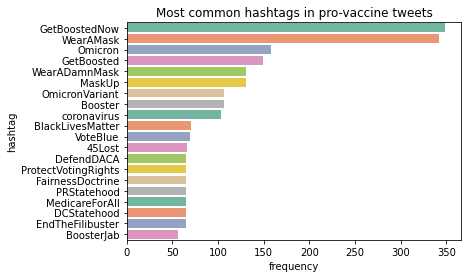

In [64]:
# plot the result
sns.barplot(x = 'frequency', y = 'hashtag', data = df_hashtag_pro, palette = 'Set2').set(title = 'Most common hashtags in pro-vaccine tweets')
plt.xticks()
plt.show()

The barplot above presents hashtags most frequently used by pro-vaxxers. Most popular ones encourage people to get the third dose of vaccine (so called "booster") and wear a mask. Other, also popular hashtags (mentioned over 50 times in our dataframe) refer to political movements (famous in US).

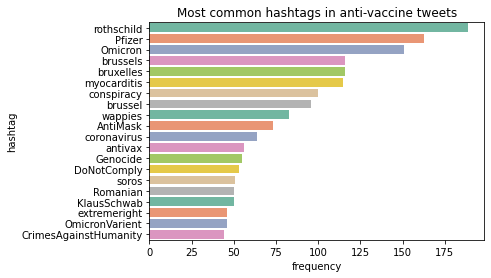

In [65]:
sns.barplot(x = 'frequency', y = 'hashtag', data = df_hashtag_anti, palette = 'Set2').set(title = 'Most common hashtags in anti-vaccine tweets')
plt.xticks()
plt.show()

The most popular hashtag for the anti-vaxxers movement turned out to be *rothschild*. It is probably connected with the newly surfaced (at that time) conspiracy theory that Rothschild patented COVID19 tests in 2017 or so. We can see also that *conspiracy* occurred quite high on the list, as well as the different spelling of Brussels (UE main headquarters).

## Part 5 - Latent Dirichlet allocation (LDA).

First, we will create a separate dataframes to be an input for LDA. We will use *word_list* column and join the words into strings.

In [234]:
lda_input_pro = pd.DataFrame([string for string in tweets_pro['word_list'].apply(lambda x: ' '.join(x))], columns = ['clean_tweet'])
lda_input_anti = pd.DataFrame([string for string in tweets_anti['word_list'].apply(lambda x: ' '.join(x))], columns = ['clean_tweet'])

In [235]:
display_side_by_side(lda_input_pro.head(), lda_input_anti.head())

,clean_tweet
0,think vaccinate children quadruple jabs force necessary virus doesnt care human rights neither #getvaccinated #getvaccinatednow #vaccineswork httpstco2czu3nlafm
1,obarromon uselogicbetter cbsnews facethenation margbrennan thats unfair characterization would much deeper shit corrupt incompetents tfgs administration still running country telling us go away like miracle without putting hard work #getvaccinatednow
2,parentmishmash leftylucieb amyriscool auntbunny22 embryethan know 3 people long covid one unvaxxed permanently disabled never leave nursing home high powered financial advisor nyc trashed whole life insurance maxed hes paying outofpocket #getvaccinatednow #wearamask
3,amyriscool parentmishmash auntbunny22 embryethan except variants come countries global pandemic governments around world need get populations vaxxed got rid polio small poxhigh global vaccination rates #getvaccinatednow #wearamask
4,karenlovecheese say thank colleagues fortitudewe would even worse situation without heroic work understaffed underpaid resourced nhs #getvaccinatednow
,clean_tweet
0,meanwhile #thegreatreset #authoritarian proving ground #australia #unvaxxed #aussies told wont allowed exercise go work httpstcoh5jmeps2da #covid19 #vaccinemandate #vaccinesideeffects #vaccieapartheid #bigpharmaprofits #covid19 #omnicronvariant
1,deaths young working age males rise #onlycovidlivesmatter #istandwithnovak #vaccinedeaths #boosterjab #omicronvarient #vaccinesideeffects httpstcoyuykjulzka
2,#fakenews #cnn medical guest lets penalize #unvaccinated americans deny affordable health insurancehe must work #bigpharma httpstcoab6o4aacaj #covid19 #vaccinemandate #vaccinesideeffects #vaccieapartheid #bigpharmaprofits #covid19 #omnicronvariant #omnicorn httpstco8okuqsjm5m
3,defibrillators defibrillators everywhere go #vaccinesideeffects httpstcofhvvmezvhr via verge


Next step will be to remove the hyperlinks and numbers and hashtags.

In [236]:
def remove_links(_tweet):
    _tweet = re.sub('([0-9]+)', '', _tweet)
    _tweet = re.sub(r'http\S+', '', _tweet)
    _tweet = re.sub(r'bit.ly/\S+', '', _tweet)
    _tweet = _tweet.strip('[link]')
    return _tweet

In [237]:
lda_input_pro['clean_tweet'] = lda_input_pro['clean_tweet'].apply(remove_links)
lda_input_anti['clean_tweet'] = lda_input_anti['clean_tweet'].apply(remove_links)

In [238]:
# remove the hashtags
lda_input_pro['clean_tweet'] = [string.replace("#", "") for string in lda_input_pro['clean_tweet']]
lda_input_anti['clean_tweet'] = [string.replace("#", "") for string in lda_input_anti['clean_tweet']]

In [239]:
display_side_by_side(lda_input_pro.head(), lda_input_anti.head())

,clean_tweet
0,think vaccinate children quadruple jabs force necessary virus doesnt care human rights neither getvaccinated getvaccinatednow vaccineswork
1,obarromon uselogicbetter cbsnews facethenation margbrennan thats unfair characterization would much deeper shit corrupt incompetents tfgs administration still running country telling us go away like miracle without putting hard work getvaccinatednow
2,parentmishmash leftylucieb amyriscool auntbunny embryethan know people long covid one unvaxxed permanently disabled never leave nursing home high powered financial advisor nyc trashed whole life insurance maxed hes paying outofpocket getvaccinatednow wearamas
3,amyriscool parentmishmash auntbunny embryethan except variants come countries global pandemic governments around world need get populations vaxxed got rid polio small poxhigh global vaccination rates getvaccinatednow wearamas
4,arenlovecheese say thank colleagues fortitudewe would even worse situation without heroic work understaffed underpaid resourced nhs getvaccinatednow
,clean_tweet
0,meanwhile thegreatreset authoritarian proving ground australia unvaxxed aussies told wont allowed exercise go work covid vaccinemandate vaccinesideeffects vaccieapartheid bigpharmaprofits covid omnicronvariant
1,deaths young working age males rise onlycovidlivesmatter istandwithnovak vaccinedeaths boosterjab omicronvarient vaccinesideeffects
2,fakenews cnn medical guest lets penalize unvaccinated americans deny affordable health insurancehe must work bigpharma covid vaccinemandate vaccinesideeffects vaccieapartheid bigpharmaprofits covid omnicronvariant omnicorn
3,defibrillators defibrillators everywhere go vaccinesideeffects via verge


Next step is to remove the words associated with covid, otherwise all the dected topics will be pandemic related, which does not makes sense. We also removed the English stopwords.

In [240]:
def remove_stopwords(_tweet):
    _tweet_list = _tweet.split()
    _tweet_processed = [s for s in _tweet_list if not any(c.isdigit() for c in s)]
    _tweet_processed = [word for word in _tweet_processed if word not in my_stopwords] #the list we used before to remove more stopwords
    _tweet_processed = ' '.join([word for word in _tweet_processed if word not in stopwords.words('english')])
    _tweet_processed = ' '.join(re.sub('.*covid.*|.*vaccin.*|.*boost.*|.*vaxx.*', '', w.lower()) for w in _tweet_processed.split())
    _tweet_processed = ' '.join(_tweet_processed.split())
    return _tweet_processed

In [241]:
lda_input_pro['clean_tweet'] = lda_input_pro['clean_tweet'].apply(remove_stopwords)
lda_input_anti['clean_tweet'] = lda_input_anti['clean_tweet'].apply(remove_stopwords)

In [242]:
display_side_by_side(lda_input_pro.head(), lda_input_anti.head())

,clean_tweet
0,think children quadruple jabs force necessary virus doesnt care human rights neither
1,obarromon uselogicbetter cbsnews facethenation margbrennan thats unfair characterization much deeper shit corrupt incompetents tfgs administration still running country telling away like miracle without putting hard work
2,parentmishmash leftylucieb amyriscool auntbunny embryethan people long permanently disabled never leave nursing home high powered financial advisor nyc trashed whole life insurance maxed hes paying outofpocket wearamas
3,amyriscool parentmishmash auntbunny embryethan except variants come countries global pandemic governments around world need populations rid polio small poxhigh global rates wearamas
4,arenlovecheese say thank colleagues fortitudewe worse situation without heroic work understaffed underpaid resourced nhs
,clean_tweet
0,meanwhile thegreatreset authoritarian proving ground australia aussies told wont allowed exercise work vaccieapartheid bigpharmaprofits omnicronvariant
1,deaths young working age males rise istandwithnovak omicronvarient
2,fakenews cnn medical guest lets penalize americans deny affordable health insurancehe must work bigpharma vaccieapartheid bigpharmaprofits omnicronvariant omnicorn
3,defibrillators defibrillators everywhere via verge


Transforming into vector form:

In [243]:
vectorizer_pro = CountVectorizer(max_df = 0.9, min_df = 10, token_pattern = '\w+|\$[\d\.]+|\S+')
vectorizer_anti = CountVectorizer(max_df = 0.9, min_df = 10, token_pattern = '\w+|\$[\d\.]+|\S+')

tf_pro = vectorizer_pro.fit_transform(lda_input_pro['clean_tweet']).toarray()
tf_anti = vectorizer_anti.fit_transform(lda_input_anti['clean_tweet']).toarray()

tf_pro_feature_names = vectorizer_pro.get_feature_names()
tf_anti_feature_names = vectorizer_anti.get_feature_names()

In [244]:
# assume 7 topics
number_of_topics = 7

model_pro = LDA(n_components = number_of_topics, random_state = 0)
model_anti = LDA(n_components = number_of_topics, random_state = 0)

In [245]:
# apply the model
model_pro.fit(tf_pro)

LatentDirichletAllocation(n_components=7, random_state=0)

In [246]:
model_anti.fit(tf_anti)

LatentDirichletAllocation(n_components=7, random_state=0)

Function that displays the top words for a topic together with their weights:

In [247]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)] = ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words -1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)] = ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words -1:-1]]
    return pd.DataFrame(topic_dict)

In [250]:
# assume 15 top words in every topic
no_top_words = 15
display_topics(model_pro, tf_pro_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights
0,right,69.7,people,118.0,christmas,254.0,wearamask,122.0,like,83.2,please,163.6,people,100.3
1,children,60.4,pandemic,82.2,wearamask,91.5,people,81.2,trump,79.2,back,118.2,spotify,89.1
2,people,60.0,omicronvariant,63.2,thank,91.3,deaths,69.9,safe,78.6,follow,107.1,good,85.3
3,maskup,54.5,need,48.0,positive,85.2,hospital,57.3,lives,78.5,lost,103.1,science,73.2
4,polio,54.1,dying,47.4,well,79.1,flu,45.7,ones,61.1,voteblue,77.1,still,60.4
5,mask,54.0,via,46.8,merry,77.1,cant,44.8,save,55.1,followed,72.1,work,54.8
6,million,49.5,coronavirus,44.8,safe,67.4,must,41.2,everyone,51.0,blacklivesmatter,70.1,trump,52.1
7,protect,42.4,yes,40.6,please,63.5,wearadamnmask,41.1,merrychristmas,49.1,endthefilibuster,65.1,health,49.0
8,thing,39.4,read,39.1,family,60.5,vax,41.0,give,46.2,dcstatehood,65.1,person,45.8
9,coronavirus,35.1,another,38.8,tested,58.8,per,39.9,medical,42.1,defenddaca,65.1,news,45.3


In [251]:
display_topics(model_anti, tf_anti_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights
0,please,85.5,people,91.4,still,92.4,side,218.9,myocarditis,125.4,conspiracy,133.2,forced,75.1
1,coronavirus,84.4,pfizer,54.0,work,59.3,effects,198.1,genocide,74.1,brussels,121.1,pfizer,74.6
2,via,82.4,good,52.6,health,57.8,people,187.7,heart,68.1,bruxelles,118.1,public,64.6
3,people,69.6,safe,47.4,pfizer,54.3,government,149.7,die,64.0,people,105.4,governments,64.1
4,deaths,56.4,great,43.1,people,51.8,australia,138.8,another,61.2,brussel,98.1,details,60.1
5,joerogan,55.6,say,42.3,death,51.0,report,132.1,like,60.1,wappies,83.1,soros,60.1
6,fauci,54.0,propaganda,39.7,big,42.4,victims,120.1,antivax,46.4,police,54.1,sign,58.1
7,children,52.4,medical,39.3,freedom,38.9,rothschild,116.5,mean,46.0,donotcomply,53.8,klausschwab,57.1
8,must,44.5,real,39.3,mandate,35.1,admits,112.1,going,46.0,extremeright,46.1,sharing,56.1
9,risk,41.3,djokovic,38.1,end,33.5,compensation,108.1,world,44.5,home,42.4,worlds,55.1


## Part 6 - Conclusions.

Twitter is the most popular social media platform for following the news and current affairs. Overall, the results of the analysis were more or less aligned with our expectations. The content of the tweets reflected not only a general user's attitude towards vaccines but also current events that may have influenced that subject.


The *tweepy* library is not the best one to deal with scraping the tweets. Even though you need to apply for an *Elevated* access on your developer account that has a limit of requests set at 2 000 000, *tweepy* will not allow you to download more than 2,5k tweets posted during the last 7 days. Also, the library downloads some tweets with an error that needs to be fixed directly in a CSV file, because it will not load properly into a pandas data frame. Other than that, the library seems to work all right. However, if someone needs more historical data and more volume, we would recommend another scraping library, such as *snscrape*.


As expected, sentiment analysis showed that tweets with anti-vaccine hashtags have negative connotations and pro-vaccine tweets have a positive one. However, it has to be taken into account that tweets with anti-vaccine hashtags are sometimes directed to the anti-vax community and are negative because they criticize the movement, not the vaccine itself.

The LDA returned 7 topics for each pro-vaccine tweets and anti-vaccine tweets. We decided to name the topics according to the top words in every subject.

**Pro-vaccine tweets:**

Topic 0 - Protecting the children

Topic 1 - New variant of the virus

Topic 2 - Stay safe during Christmas

Topic 3 - Wear a mask to stay safe

Topic 4 - Community staying safe during holidays

Topic 5 - Political pro-blue party

Topic 6 - Media about pandemic

**Anti-vaccine tweets:**

Topic 0 - Misinformation about vaccines

Topic 1 - Anti-vaccine propaganda

Topic 2 - Freedom of "choice"

Topic 3 - Vaccine side effects

Topic 4 - Deaths caused by the vaccine

Topic 5 - Conspiracy theories about vaccines connected to the UE

Topic 6 - General conspiracy theories about vaccines

Altogether, one of the challenges we encountered was the fact that tweets can be written by anyone, therefore there is no unique style or vocabulary used. Some mistakes may happen, e.g. misspelling, that may influence the outcome of the analysis. The use of hashtags itself creates some obstacles. They are often used interchangeably with actual words or consist of more than one word 'glued' together. If we had a chance to create a bigger database, the analysis of hashtag use could even be a topic for a separate project.